### In my opinion this project truly highlights the importance of choosing proper training data as the model is very sensitive to the training data choice.  

     In the begining I spent trying simple models with the data set provided by Udacity. I incorporated, left and right images , changing brigtness and flipping images using training generator as told in lectures but car always seems to go out of road after crossing the bridge.  
     
    In 2nd part i tried Nvidia model with the udacity data. Model is taking too much time so i added max pooling layer in Nvida model to do faster training but still car is going off road after crosing bridge. Model is able to run quite well in straight road with not so sharp turn but it fails to perform well for sharp turns. 
    
    To solve above issue i collected data using simulator for sharp turns and as well as training data from mountain track. In training data i changed logic to add images which as steering angle more than 2 so that model should be able to learn important turns etc.  
    
    Also during final testing i observed car has velocity set to 9 but i was collecting simulator data at max speed around 30 . despite model is not learning steering angle with speed but i feeel it is important at what speed simulator data is collected as at higher speed less steering angle is sufficient at sharp turns while at slow speed higher steering angle is required at low speed. So itried collecting above data at speed 9 .    


In [1]:
## Imports
import glob
import os
from PIL import Image
import csv
import numpy as np
import cv2
import random
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

## Link to Udacity's sample data
paths = "data/"
os.chdir(r"data/data")
%matplotlib inline

In [2]:

## Link to my collected  data
path_mydata = "data/"
cwd = os.getcwd()
print(cwd)
#Check size of images
new_path = os.path.join(cwd, "IMG/", "*.jpg")
print(new_path)
for infile in glob.glob(new_path)[:2]:
    im = Image.open(infile)
    print(im.size, im.mode)

/media/ashutosh/unix-extra1/udacity/udacitycCarND/Behavioral Cloning/data/data
/media/ashutosh/unix-extra1/udacity/udacitycCarND/Behavioral Cloning/data/data/IMG/*.jpg
(320, 160) RGB
(320, 160) RGB


In [2]:

# Import as a dataframe and plot steering
df = pd.read_csv('driving_log.csv', header=0)
df.columns = ["center_image", "left_image", "right_image", "steering", "throttle", "break", "speed"]
df.drop(['throttle', 'break', 'speed'], axis = 1, inplace = True)


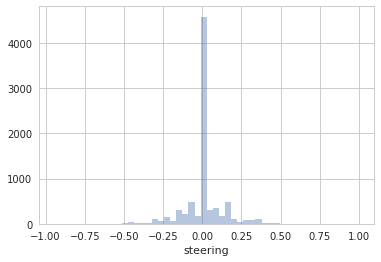

In [30]:

import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
sns.distplot(df['steering'], kde = False)



Characteristics of the data:
* All images are 320x160 pixels
* The data is heavily skewed to zero steering as shown below:

In [7]:
print(len(df))

8036


In [32]:
dftoList=df.values.tolist()

In [33]:
# Break into training and validation samples
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(dftoList, test_size=0.20)

In [34]:

print(len(train_samples), len(validation_samples))
batch_size = 128

6428 1608


#### We built training and validation generator using left , right and straight images. Also added random brightness and flipped images to have equal data for left as well as right steering data . Also most of the time car is going straight so i added logic that in every batch to model training add 50% images having angle less tha 2 and rest traing data having steering angle more than 2.


In [59]:
# Start with train generator shared in the class and add image augmentations
def train_generator(samples, batch_size=batch_size):
    num_samples = len(samples)
    print(num_samples)
    while 1: # Loop forever so the generator never terminates
        from sklearn.utils import shuffle
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            straight_count=0
            images = []
            angles = []
            #print(batch_samples[0])
            # Read center, left and right images from a folder containing Udacity data and my data
            for sample_index,batch_sample in enumerate(batch_samples):
                cwd = os.getcwd()
                #print(cwd)
                #print(batch_sample)
                
                #print(batch_sample)
                center_angle = float(batch_sample[3])                
                # Limit angles of less than absolute value of .1 to no more than 1/2 of data
                # to reduce bias of car driving straight
                if abs(center_angle) < .1:
                    straight_count += 1
                if straight_count > (batch_size * .5):
                    while abs(batch_samples[sample_index][3]) < .1:
                        sample_index = random.randrange(len(batch_samples))
                    
                    batch_sample=batch_samples[sample_index]
                    
                center_name = cwd+'/'+batch_sample[0].strip()#.split('/')[-1]
                if Path(center_name).exists():
                    center_image = cv2.imread(center_name)
                else:
                    print("not Found:-"+str(center_name))
                    continue
                #print(center_image.shape)
                #center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
                
                left_name = cwd+'/'+batch_sample[1].strip()#.split('/')[-1]
                if Path(left_name).exists():
                    left_image = cv2.imread(left_name)
                else:
                    print("not Found:-"+str(left_name))
                    continue
                #left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
                
                right_name = cwd+'/'+batch_sample[2].strip()#.split('/')[-1]
                if Path(right_name).exists():
                    right_image = cv2.imread(right_name)
                else:
                    print("not Found:-"+str(batch_sample))
                    continue
                #right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)


                
                # Apply correction for left and right steering
                correction = 0.20
                left_angle = center_angle + correction
                right_angle = center_angle - correction

                # Randomly include either center, left or right image
                num = random.random()
                #print(num)
                if num <= 0.33:
                    select_image = center_image
                    select_angle = center_angle
                    images.append(select_image)
                    angles.append(select_angle)
                elif num>0.33 and num<=0.66:
                    select_image = left_image
                    select_angle = left_angle
                    images.append(select_image)
                    angles.append(select_angle)
                    #print(select_image)
                else:
                    select_image = right_image
                    select_angle = right_angle
                    images.append(select_image)
                    angles.append(select_angle)
                    #print(select_image)

                # Randomly horizontally flip selected images with 80% probability
                keep_prob = random.random()
                if keep_prob >0.20:
                    #print(select_image)
                    flip_image = np.fliplr(select_image)
                    flip_angle = -1*select_angle
                    images.append(flip_image)
                    angles.append(flip_angle)

                # Augment with images of different brightness
                # Randomly select a percent change
                change_pct = random.uniform(0.4, 1.2)

                # Change to HSV to change the brightness V
                hsv = cv2.cvtColor(select_image, cv2.COLOR_RGB2HSV)

                hsv[:, :, 2] = hsv[:, :, 2] * change_pct
                # Convert back to RGB and append

                bright_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
                images.append(bright_img)
                angles.append(select_angle)

                ## Randomly shear image with 80% probability
                shear_prob = random.random()
                if shear_prob >=0.20:
                    shear_range = 40
                    rows, cols, ch = select_image.shape
                    dx = np.random.randint(-shear_range, shear_range + 1)
                    #    print('dx',dx)
                    random_point = [cols / 2 + dx, rows / 2]
                    pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
                    pts2 = np.float32([[0, rows], [cols, rows], random_point])
                    dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 10.0
                    M = cv2.getAffineTransform(pts1, pts2)
                    shear_image = cv2.warpAffine(center_image, M, (cols, rows), borderMode=1)
                    shear_angle = select_angle + dsteering
                    images.append(shear_image)
                    angles.append(shear_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            print(X_train.shape)
            yield shuffle(X_train, y_train)

def valid_generator(samples, batch_size=batch_size):
        num_samples = len(samples)
        print(cwd)
        while 1:  # Loop forever so the generator never terminates
            from sklearn.utils import shuffle
            shuffle(samples)
            for offset in range(0, num_samples, batch_size):
                batch_samples = samples[offset:offset + batch_size]

                images = []
                angles = []
               
                #Validation generator only has center images and no augmentations
                for batch_sample in batch_samples:
                    
                    #print(batch_sample)
                    center_name = cwd+'/' + batch_sample[0].strip()#.split('/')[-1]
                    if Path(center_name).exists():
                        center_image = cv2.imread(center_name)
                    else:
                        print("not Found:-"+str(center_name))
                        continue
                    
                    #center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)

                    center_angle = float(batch_sample[3])

                    images.append(center_image)
                    angles.append(center_angle)

                X_train = np.array(images)
                y_train = np.array(angles)
                print(X_train.shape)
                yield shuffle(X_train, y_train)



In [7]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation
from keras.layers.convolutional import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop


Using TensorFlow backend.


In [13]:
def resize_normalize(image):
    import cv2
    from keras.backend import tf as ktf   
    
    # resize to width 200 and high 66 liek recommended
    # in the nvidia paper for the used CNN
    # image = cv2.resize(image, (66, 200)) #first try
    resized = ktf.image.resize_images(image, (64, 64))
    #normalize 0-1
    resized = resized/255.0 - 0.5

    return resized

In [9]:

#Params
row, col, ch = 160, 320, 3
nb_classes = 1


In [165]:

model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(row, col, ch)))
# Crop pixels from top and bottom of image
model.add(Cropping2D(cropping=((60, 20), (0, 0))))

# Resise data within the neural network
model.add(Lambda(resize_normalize))

# First convolution layer so the model can automatically figure out the best color space for the hypothesis
model.add(Convolution2D(3, 1, 1, border_mode='same', name='color_conv'))

# CNN model

model.add(Convolution2D(32, 3,3 ,border_mode='same', subsample=(2,2), name='conv1'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(1,1), name='pool1'))

model.add(Convolution2D(64, 3,3 ,border_mode='same',subsample=(2,2), name='conv2'))
model.add(Activation('relu',name='relu2'))
model.add(MaxPooling2D(pool_size=(2,2), name='pool2'))

model.add(Convolution2D(128, 3,3,border_mode='same',subsample=(1,1), name='conv3'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size= (2,2), name='pool3'))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(128, name='dense1'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(128, name='dense2'))

model.add(Dense(1,name='output'))

model.compile(optimizer=Adam(lr= 0.0001), loss="mse")


In [166]:
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding2d_8 (ZeroPadding2D)  (None, 162, 322, 3)   0           zeropadding2d_input_8[0][0]      
____________________________________________________________________________________________________
cropping2d_8 (Cropping2D)        (None, 82, 322, 3)    0           zeropadding2d_8[0][0]            
____________________________________________________________________________________________________
lambda_12 (Lambda)               (None, 64, 64, 3)     0           cropping2d_8[0][0]               
____________________________________________________________________________________________________
color_conv (Convolution2D)       (None, 64, 64, 3)     12          lambda_12[0][0]                  
___________________________________________________________________________________________

In [10]:
#save every model using Keras checkpoint
from keras.callbacks import ModelCheckpoint
filepath="check-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath= filepath, verbose=1, save_best_only=False)
callbacks_list = [checkpoint]

In [26]:

nb_epoch = 5
samples_per_epoch = 2000
nb_val_samples = 2000


In [47]:
train_generator = train_generator(train_samples, batch_size=batch_size)
validation_generator = valid_generator(validation_samples, batch_size=batch_size)

In [170]:
#Model fit generator
history_object = model.fit_generator(train_generator, samples_per_epoch= samples_per_epoch,
                                     validation_data=validation_generator,
                                     nb_val_samples=nb_val_samples, nb_epoch=nb_epoch, verbose=1, callbacks=callbacks_list)


6428
Epoch 1/15
(469, 160, 320, 3)
(456, 160, 320, 3)
(472, 160, 320, 3)
  925/20000 [>.............................] - ETA: 87s - loss: 0.0590 (452, 160, 320, 3)
(457, 160, 320, 3)
 1397/20000 [=>............................] - ETA: 80s - loss: 0.0575(465, 160, 320, 3)
(456, 160, 320, 3)
 1855/20000 [=>............................] - ETA: 76s - loss: 0.0554(464, 160, 320, 3)
(461, 160, 320, 3)
 2764/20000 [===>..........................] - ETA: 69s - loss: 0.0544(470, 160, 320, 3)
(450, 160, 320, 3)
 3229/20000 [===>..........................] - ETA: 83s - loss: 0.0538(471, 160, 320, 3)
(459, 160, 320, 3)
 4149/20000 [=====>........................] - ETA: 114s - loss: 0.0506(467, 160, 320, 3)
(462, 160, 320, 3)
 4610/20000 [=====>........................] - ETA: 120s - loss: 0.0495(466, 160, 320, 3)
(455, 160, 320, 3)
 5528/20000 [=======>......................] - ETA: 127s - loss: 0.0473(460, 160, 320, 3)
(462, 160, 320, 3)
19852/20000 [============================>.] - ETA: 1s - lo

/media/ashutosh/unix-extra1/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


/media/ashutosh/unix-extra1/udacity/udacitycCarND/Behavioral Cloning/data
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(72, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(72, 160, 320, 3)
(128, 160, 320, 3)
Epoch 00000: saving model to check-00-0.0128.hdf5
20320/20000 [==============================] - 214s - loss: 0.0421 - val_loss: 0.0128
Epoch 2/15
(458, 160, 320, 3)
 2873/20000 [===>..........................] - ETA: 65s - loss: 0.0359(460, 160, 320, 3)
(456, 160, 320, 3)
19912/20000 [============================>.] - ETA: 0s - loss: 0.0334(456, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320,

11160/20000 [===============>..............] - ETA: 31s - loss: 0.0278(449, 160, 320, 3)
(462, 160, 320, 3)
19871/20000 [============================>.] - ETA: 0s - loss: 0.0273(459, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(72, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(72, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
Epoch 00004: saving model to check-04-0.0113.hdf5
20326/20000 [==============================] - 80s - loss: 0.0273 - val_loss: 0.0113
Epoch 6/15
(466, 160, 320, 3)
13943/20000 [===================>..........] - ETA: 24s - loss: 0.0257(465, 160, 320, 3)
(465, 160, 320, 3)
19923/20000 [=======

19804/20000 [============================>.] - ETA: 0s - loss: 0.0227(451, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(72, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(72, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
Epoch 00008: saving model to check-08-0.0109.hdf5
20268/20000 [==============================] - 79s - loss: 0.0226 - val_loss: 0.0109
Epoch 10/15
(461, 160, 320, 3)
 1960/20000 [=>............................] - ETA: 67s - loss: 0.0227(457, 160, 320, 3)
(470, 160, 320, 3)
19989/20000 [============================>.] - ETA: 0s - loss: 0.0224(463, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(

(72, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(72, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
Epoch 00009: saving model to check-09-0.0114.hdf5
20443/20000 [==============================] - 81s - loss: 0.0223 - val_loss: 0.0114
Epoch 11/15
(101, 160, 320, 3)
 4686/20000 [======>.......................] - ETA: 56s - loss: 0.0229(460, 160, 320, 3)
(456, 160, 320, 3)
19932/20000 [============================>.] - ETA: 0s - loss: 0.0213(454, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(72, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320

13000/20000 [==================>...........] - ETA: 26s - loss: 0.0208(448, 160, 320, 3)
(462, 160, 320, 3)
19912/20000 [============================>.] - ETA: 0s - loss: 0.0206(464, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(72, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(72, 160, 320, 3)
(128, 160, 320, 3)
Epoch 00013: saving model to check-13-0.0103.hdf5
20367/20000 [==============================] - 83s - loss: 0.0208 - val_loss: 0.0103
Epoch 15/15
(454, 160, 320, 3)
15782/20000 [======================>.......] - ETA: 15s - loss: 0.0209(467, 160, 320, 3)
(456, 160, 320, 3)
19910/20000 [======

dict_keys(['loss', 'val_loss'])


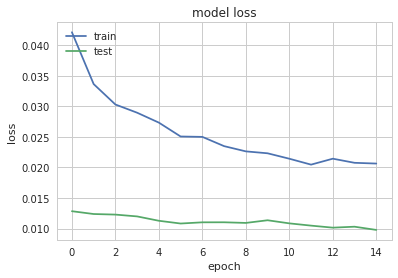

In [171]:

#Plot losses
import matplotlib.pyplot as plt

print(history_object.history.keys())
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

I saw that the validation score leveled off at around epoch 15, suggesting that the model was overfitting after that point, and testing epochs 10-20 found that epoch 15 performed the best (getting to the turn after the bridge).

In [173]:

#Save model
from keras.models import model_from_json

# go one level up to save final model
model_json = model.to_json()
with open("model_final.json", "w") as json_file:
    json_file.write(model_json)


model.save("model_final.h5")
print("Saved model to disk")

print(model.summary())
# go one level up to save final model for simulator driver.py
os.path.dirname(os.path.dirname(cwd))
model.save("model_final.h5")

Saved model to disk
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding2d_8 (ZeroPadding2D)  (None, 162, 322, 3)   0           zeropadding2d_input_8[0][0]      
____________________________________________________________________________________________________
cropping2d_8 (Cropping2D)        (None, 82, 322, 3)    0           zeropadding2d_8[0][0]            
____________________________________________________________________________________________________
lambda_12 (Lambda)               (None, 64, 64, 3)     0           cropping2d_8[0][0]               
____________________________________________________________________________________________________
color_conv (Convolution2D)       (None, 64, 64, 3)     12          lambda_12[0][0]                  
_______________________________________________________________________

In [4]:
import imageio

In [5]:
imageio.plugins.ffmpeg.download()

### Above approch causes to the car to drive on to dirt just after crossing the bridge. Two approach i think is may be usefull first to add more data corresponding to non staright driving as  data is skewed towards driving car in staring line. Second better architecture like Nvidia driving is usefull.

Nvidia architecture just added max pooling layer for faster convergence.

![title](nVidia_model.png)

In [14]:
model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(row, col, ch)))
# Crop pixels from top and bottom of image
model.add(Cropping2D(cropping=((60, 20), (0, 0))))

# Resise data within the neural network
model.add(Lambda(resize_normalize))

model.add(Convolution2D(24, 5, 5, border_mode='same', subsample=(2, 2)))
model.add(Activation('relu',name='relu1'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
model.add(Convolution2D(36, 5, 5, border_mode='same', subsample=(2, 2)))
model.add(Activation('relu',name='relu2'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
model.add(Convolution2D(48, 5, 5, border_mode='same', subsample=(2, 2)))
model.add(Activation('relu',name='relu3'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
model.add(Convolution2D(64, 3, 3, border_mode='same', subsample=(1, 1)))
model.add(Activation('relu',name='relu4'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
model.add(Convolution2D(64, 3, 3, border_mode='same', subsample=(1, 1)))
model.add(Activation('relu',name='relu5'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
model.add(Flatten())
model.add(Dense(1164))
model.add(Activation('relu',name='relu6'))
model.add(Dense(100))
model.add(Activation('relu',name='relu7'))
model.add(Dense(50))
model.add(Activation('relu',name='relu8'))
model.add(Dense(10))
model.add(Activation('relu',name='relu9'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr= 0.0001), loss="mse", )

In [15]:
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding2d_2 (ZeroPadding2D)  (None, 162, 322, 3)   0           zeropadding2d_input_2[0][0]      
____________________________________________________________________________________________________
cropping2d_2 (Cropping2D)        (None, 82, 322, 3)    0           zeropadding2d_2[0][0]            
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 64, 64, 3)     0           cropping2d_2[0][0]               
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 32, 32, 24)    1824        lambda_1[0][0]                   
___________________________________________________________________________________________

In [16]:
#save every model using Keras checkpoint
from keras.callbacks import ModelCheckpoint
filepath="Nvidias-check-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath= filepath, verbose=1, save_best_only=False)
callbacks_list = [checkpoint]

In [18]:

nb_epoch = 8
samples_per_epoch = 2000
nb_val_samples = 2000


In [60]:
train_generator = train_generator(train_samples, batch_size=batch_size)
validation_generator = valid_generator(validation_samples, batch_size=batch_size)

In [58]:
history_object = model.fit_generator(train_generator, samples_per_epoch= samples_per_epoch,
                                     validation_data=validation_generator,
                                     nb_val_samples=nb_val_samples, nb_epoch=nb_epoch, verbose=1, callbacks=callbacks_list)


6428
Epoch 1/25
(470, 160, 320, 3)
(461, 160, 320, 3)
 1865/20000 [=>............................] - ETA: 96s - loss: 0.0204(448, 160, 320, 3)
(457, 160, 320, 3)
 6020/20000 [========>.....................] - ETA: 68s - loss: 0.0198(458, 160, 320, 3)
(462, 160, 320, 3)
 6485/20000 [========>.....................] - ETA: 65s - loss: 0.0198(460, 160, 320, 3)
(467, 160, 320, 3)
 6939/20000 [=========>....................] - ETA: 64s - loss: 0.0198(460, 160, 320, 3)
(452, 160, 320, 3)
 7397/20000 [==========>...................] - ETA: 62s - loss: 0.0196(469, 160, 320, 3)
(464, 160, 320, 3)
 7859/20000 [==========>...................] - ETA: 59s - loss: 0.0196(463, 160, 320, 3)
(457, 160, 320, 3)
 8319/20000 [===========>..................] - ETA: 57s - loss: 0.0194(458, 160, 320, 3)
(462, 160, 320, 3)
 8786/20000 [============>.................] - ETA: 55s - loss: 0.0193(472, 160, 320, 3)
(463, 160, 320, 3)
(454, 160, 320, 3)
19859/20000 [============================>.] - ETA: 0s - loss: 

/media/ashutosh/unix-extra1/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


/media/ashutosh/unix-extra1/udacity/udacitycCarND/Behavioral Cloning/data/data
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(72, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(72, 160, 320, 3)
(128, 160, 320, 3)
Epoch 00000: saving model to Nvidias-check-00-0.0116.hdf5
20318/20000 [==============================] - 102s - loss: 0.0198 - val_loss: 0.0116
Epoch 2/25
(457, 160, 320, 3)
 2870/20000 [===>..........................] - ETA: 77s - loss: 0.0205(442, 160, 320, 3)
(455, 160, 320, 3)
19871/20000 [============================>.] - ETA: 0s - loss: 0.0196(456, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(1

11195/20000 [===============>..............] - ETA: 37s - loss: 0.0198(467, 160, 320, 3)
(470, 160, 320, 3)
19938/20000 [============================>.] - ETA: 0s - loss: 0.0193(459, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(72, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(72, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
Epoch 00004: saving model to Nvidias-check-04-0.0120.hdf5
20401/20000 [==============================] - 91s - loss: 0.0193 - val_loss: 0.0120
Epoch 6/25
(462, 160, 320, 3)
13950/20000 [===================>..........] - ETA: 27s - loss: 0.0195(470, 160, 320, 3)
(461, 160, 320, 3)
19955/20000 

19814/20000 [============================>.] - ETA: 0s - loss: 0.0185(473, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(72, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(72, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
Epoch 00008: saving model to Nvidias-check-08-0.0113.hdf5
20286/20000 [==============================] - 97s - loss: 0.0186 - val_loss: 0.0113
Epoch 10/25
(468, 160, 320, 3)
 1946/20000 [=>............................] - ETA: 83s - loss: 0.0184(453, 160, 320, 3)
(456, 160, 320, 3)
19910/20000 [============================>.] - ETA: 0s - loss: 0.0180(463, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 3

(128, 160, 320, 3)
(72, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(72, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
Epoch 00009: saving model to Nvidias-check-09-0.0104.hdf5
20366/20000 [==============================] - 96s - loss: 0.0181 - val_loss: 0.0104
Epoch 11/25
(100, 160, 320, 3)
 4709/20000 [======>.......................] - ETA: 64s - loss: 0.0196(453, 160, 320, 3)
(456, 160, 320, 3)
19924/20000 [============================>.] - ETA: 0s - loss: 0.0181(464, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(72, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 

13015/20000 [==================>...........] - ETA: 30s - loss: 0.0188(455, 160, 320, 3)
(457, 160, 320, 3)
19905/20000 [============================>.] - ETA: 0s - loss: 0.0183(467, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(72, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(72, 160, 320, 3)
(128, 160, 320, 3)
Epoch 00013: saving model to Nvidias-check-13-0.0110.hdf5
20366/20000 [==============================] - 92s - loss: 0.0182 - val_loss: 0.0110
Epoch 15/25
(454, 160, 320, 3)
15758/20000 [======================>.......] - ETA: 17s - loss: 0.0183(469, 160, 320, 3)
(466, 160, 320, 3)
19906/20000

19973/20000 [============================>.] - ETA: 0s - loss: 0.0178(469, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(72, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(72, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
Epoch 00017: saving model to Nvidias-check-17-0.0109.hdf5
20432/20000 [==============================] - 91s - loss: 0.0178 - val_loss: 0.0109
Epoch 19/25
(457, 160, 320, 3)
 3794/20000 [====>.........................] - ETA: 74s - loss: 0.0196(463, 160, 320, 3)
(456, 160, 320, 3)
19907/20000 [============================>.] - ETA: 0s - loss: 0.0177(465, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 3

(128, 160, 320, 3)
(72, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(72, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
Epoch 00018: saving model to Nvidias-check-18-0.0113.hdf5
20373/20000 [==============================] - 96s - loss: 0.0177 - val_loss: 0.0113
Epoch 20/25
(460, 160, 320, 3)
 6538/20000 [========>.....................] - ETA: 58s - loss: 0.0186(458, 160, 320, 3)
(454, 160, 320, 3)
19930/20000 [============================>.] - ETA: 0s - loss: 0.0176(467, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(72, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 

14830/20000 [=====================>........] - ETA: 21s - loss: 0.0181(461, 160, 320, 3)
(455, 160, 320, 3)
19912/20000 [============================>.] - ETA: 0s - loss: 0.0178(456, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(72, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(72, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
Epoch 00022: saving model to Nvidias-check-22-0.0102.hdf5
20374/20000 [==============================] - 92s - loss: 0.0178 - val_loss: 0.0102
Epoch 24/25
(446, 160, 320, 3)
17610/20000 [=========================>....] - ETA: 10s - loss: 0.0178(466, 160, 320, 3)
(460, 160, 320, 3)
19910/20000

In [66]:
#Plot losses
import matplotlib.pyplot as plt

print(history_object.history.keys())
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history_object' is not defined

In [62]:
# go one level up to save final model
model_json = model.to_json()
with open("model_final.json", "w") as json_file:
    json_file.write(model_json)


model.save("model_final.h5")
print("Saved model to disk")


Saved model to disk


### Added more data to training using simulator as car goes outside track after crossing bridge. Also added logic to add equal data of images having steering angle less than .2 and images having steering angle more than .2 so that car is able to run properly  in sharp turning roads.

In [20]:

from keras.models import load_model
import h5py

In [21]:
f = h5py.File("model_final.h5", mode='r')

In [22]:

model = load_model("model_final.h5")
print(model)

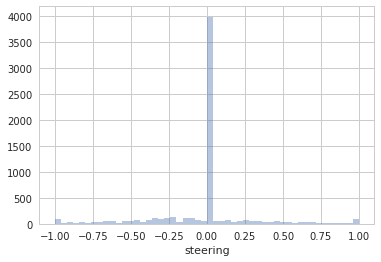

In [36]:
# Import as a dataframe and plot steering
df2 = pd.read_csv('/media/ashutosh/unix-extra1/udacity/udacitycCarND/Behavioral Cloning/linux_sim/IMG/driving_log.csv', header=0)
df2.columns = ["center_image", "left_image", "right_image", "steering", "throttle", "break", "speed"]
df2.drop(['throttle', 'break', 'speed'], axis = 1, inplace = True)

sns.set(style="whitegrid", color_codes=True)
sns.distplot(df2['steering'], kde = False)


In [48]:
# Start with train generator shared in the class and add image augmentations
def train_generator2(samples, batch_size=batch_size):
    num_samples = len(samples)
    print(num_samples)
    while 1: # Loop forever so the generator never terminates
        from sklearn.utils import shuffle
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            straight_count=0
            images = []
            angles = []
            #print(batch_samples[0])
            # Read center, left and right images from a folder containing Udacity data and my data
            for sample_index,batch_sample in enumerate(batch_samples):
                cwd = os.getcwd()
                #print(cwd)
                #print(batch_sample)
                
                #print(batch_sample)
                center_angle = float(batch_sample[3])                
                # Limit angles of less than absolute value of .1 to no more than 1/2 of data
                # to reduce bias of car driving straight
                if abs(center_angle) < .4:
                    straight_count += 1
                if straight_count > (batch_size * .3):
                    while abs(samples[sample_index][3]) < .4:
                        sample_index = random.randrange(len(samples))
                    
                    batch_sample=samples[sample_index]
                    
                center_name = batch_sample[0].strip()#.split('/')[-1]
                if Path(center_name).exists():
                    center_image = cv2.imread(center_name)
                else:
                    print("not Found:-"+str(center_name))
                    continue
                #print(center_image.shape)
                center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
                
                left_name = batch_sample[1].strip()#.split('/')[-1]
                if Path(left_name).exists():
                    left_image = cv2.imread(left_name)
                    left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
                else:
                    print("not Found:-"+str(left_name))
                    continue
                #left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
                
                right_name = batch_sample[2].strip()#.split('/')[-1]
                if Path(right_name).exists():
                    right_image = cv2.imread(right_name)
                    right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)
                else:
                    print("not Found:-"+str(batch_sample))
                    continue
                #right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)


                
                # Apply correction for left and right steering
                correction = 0.20
                left_angle = center_angle + correction
                right_angle = center_angle - correction

                # Randomly include either center, left or right image
                num = random.random()
                #print(num)
                if num <= 0.33:
                    select_image = center_image
                    select_angle = center_angle
                    images.append(select_image)
                    angles.append(select_angle)
                elif num>0.33 and num<=0.66:
                    select_image = left_image
                    select_angle = left_angle
                    images.append(select_image)
                    angles.append(select_angle)
                    #print(select_image)
                else:
                    select_image = right_image
                    select_angle = right_angle
                    images.append(select_image)
                    angles.append(select_angle)
                    #print(select_image)

                # Randomly horizontally flip selected images with 80% probability
                flip_image = np.fliplr(select_image)
                flip_angle = -1*select_angle
                images.append(flip_image)
                angles.append(flip_angle)

                # Augment with images of different brightness
                # Randomly select a percent change
                change_pct = random.uniform(0.4, 1.2)

                # Change to HSV to change the brightness V
                hsv = cv2.cvtColor(select_image, cv2.COLOR_RGB2HSV)

                hsv[:, :, 2] = hsv[:, :, 2] * change_pct
                # Convert back to RGB and append
                bright_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
                images.append(bright_img)
                angles.append(select_angle)

                ## Randomly shear image with 80% probability
                shear_range = 40
                rows, cols, ch = select_image.shape
                dx = np.random.randint(-shear_range, shear_range + 1)
                #    print('dx',dx)
                random_point = [cols / 2 + dx, rows / 2]
                pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
                pts2 = np.float32([[0, rows], [cols, rows], random_point])
                dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 10.0
                M = cv2.getAffineTransform(pts1, pts2)
                shear_image = cv2.warpAffine(center_image, M, (cols, rows), borderMode=1)
                shear_angle = select_angle + dsteering
                images.append(shear_image)
                angles.append(shear_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            print(X_train.shape)
            yield shuffle(X_train, y_train)

def valid_generator2(samples, batch_size=batch_size):
        num_samples = len(samples)
        cwd = os.getcwd()
        print(cwd)
        while 1:  # Loop forever so the generator never terminates
            from sklearn.utils import shuffle
            shuffle(samples)
            for offset in range(0, num_samples, batch_size):
                batch_samples = samples[offset:offset + batch_size]

                images = []
                angles = []
                straight_count=0
                #Validation generator only has center images and no augmentations
                for sample_index,batch_sample in enumerate(batch_samples):
                    
                    center_angle = float(batch_sample[3])
                    # Limit angles of less than absolute value of .1 to no more than 1/2 of data
                    # to reduce bias of car driving straight
                    if abs(center_angle) < .4:
                        straight_count += 1
                    if straight_count > (batch_size * .5):
                        while abs(batch_samples[sample_index][3]) < .4:
                            sample_index = random.randrange(len(batch_samples))
                        batch_sample=batch_samples[sample_index]  
                        
                    #print(batch_sample)
                    center_name =  batch_sample[0].strip()#.split('/')[-1]
                    if Path(center_name).exists():
                        center_image = cv2.imread(center_name)
                    else:
                        print("not Found:-"+str(center_name))
                        continue
                    
                    center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)

                      
                            
                    images.append(center_image)
                    angles.append(center_angle)

                X_train = np.array(images)
                y_train = np.array(angles)
                print(X_train.shape)
                yield shuffle(X_train, y_train)



In [62]:

nb_epoch = 20
samples_per_epoch = 20000
nb_val_samples = 2000


In [63]:
dftoList2=df2.values.tolist()
train_samples2, validation_samples2 = train_test_split(dftoList2, test_size=0.20)
training_generator2 = train_generator2(train_samples2, batch_size=batch_size)
validation_generator2 = valid_generator2(validation_samples2, batch_size=batch_size)

In [65]:
history_object2 = model.fit_generator(training_generator2, samples_per_epoch= samples_per_epoch,
                                     validation_data=validation_generator2,
                                     nb_val_samples=nb_val_samples, nb_epoch=nb_epoch, verbose=1, callbacks=callbacks_list)


Epoch 1/20
(512, 160, 320, 3)
(512, 160, 320, 3)
(512, 160, 320, 3)
  512/20000 [..............................] - ETA: 94s - loss: 0.0940(512, 160, 320, 3)
(512, 160, 320, 3)
 1024/20000 [>.............................] - ETA: 80s - loss: 0.0997(512, 160, 320, 3)
(512, 160, 320, 3)
 1536/20000 [=>............................] - ETA: 75s - loss: 0.1029(512, 160, 320, 3)
(512, 160, 320, 3)
 2048/20000 [==>...........................] - ETA: 72s - loss: 0.0984(512, 160, 320, 3)
(512, 160, 320, 3)
 2560/20000 [==>...........................] - ETA: 69s - loss: 0.0984(512, 160, 320, 3)
(512, 160, 320, 3)
 3072/20000 [===>..........................] - ETA: 66s - loss: 0.0989(512, 160, 320, 3)
(512, 160, 320, 3)
 3584/20000 [====>.........................] - ETA: 64s - loss: 0.0984(512, 160, 320, 3)
(512, 160, 320, 3)
 4096/20000 [=====>........................] - ETA: 61s - loss: 0.0996(512, 160, 320, 3)
(512, 160, 320, 3)
16424/20000 [=======================>......] - ETA: 12s - loss: 0.09

/media/ashutosh/unix-extra1/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
Epoch 00000: saving model to Nvidias-check-00-0.0841.hdf5
20008/20000 [==============================] - 77s - loss: 0.0959 - val_loss: 0.0841
Epoch 2/20
(512, 160, 320, 3)
16936/20000 [========================>.....] - ETA: 11s - loss: 0.0964(512, 160, 320, 3)
(512, 160, 320, 3)
19496/20000 [============================>.] - ETA: 1s - loss: 0.0973(512, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160,

(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
Epoch 00002: saving model to Nvidias-check-02-0.0910.hdf5
20008/20000 [==============================] - 87s - loss: 0.0967 - val_loss: 0.0910
Epoch 4/20
(512, 160, 320, 3)
17960/20000 [=========================>....] - ETA: 8s - loss: 0.0950(512, 160, 320, 3)
(512, 160, 320, 3)
19496/20000 [============================>.] - ETA: 2s - loss: 0.0956(512, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 

(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
Epoch 00004: saving model to Nvidias-check-04-0.0826.hdf5
20008/20000 [==============================] - 86s - loss: 0.0953 - val_loss: 0.0826
Epoch 6/20
(512, 160, 320, 3)
18984/20000 [===========================>..] - ETA: 4s - loss: 0.0947(512, 160, 320, 3)
(512, 160, 320, 3)
19496/20000 [============================>.] - ETA: 2s - loss: 0.0944(512, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 

(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
Epoch 00006: saving model to Nvidias-check-06-0.0891.hdf5
20008/20000 [==============================] - 89s - loss: 0.0947 - val_loss: 0.0891
Epoch 8/20
(512, 160, 320, 3)
19968/20000 [============================>.] - ETA: 0s - loss: 0.0954(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(512, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 

(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
Epoch 00008: saving model to Nvidias-check-08-0.0841.hdf5
20480/20000 [==============================] - 91s - loss: 0.0950 - val_loss: 0.0841
Epoch 10/20
   40/20000 [..............................] - ETA: 287s - loss: 0.0100(512, 160, 320, 3)
(512, 160, 320, 3)
19496/20000 [============================>.] - ETA: 2s - loss: 0.0933(512, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 320, 3)
(128, 16

(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
Epoch 00010: saving model to Nvidias-check-10-0.0857.hdf5
20008/20000 [==============================] - 88s - loss: 0.0944 - val_loss: 0.0857
Epoch 12/20
(512, 160, 320, 3)
 1064/20000 [>.............................] - ETA: 73s - loss: 0.1117(512, 160, 320, 3)
(512, 160, 320, 3)
19496/20000 [============================>.] - ETA: 2s - loss: 0.0942(512, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160

(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
Epoch 00012: saving model to Nvidias-check-12-0.0839.hdf5
20008/20000 [==============================] - 90s - loss: 0.0947 - val_loss: 0.0839
Epoch 14/20
(512, 160, 320, 3)
 2088/20000 [==>...........................] - ETA: 67s - loss: 0.1028(512, 160, 320, 3)
(512, 160, 320, 3)
19496/20000 [============================>.] - ETA: 2s - loss: 0.0928(512, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160

(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
Epoch 00014: saving model to Nvidias-check-14-0.0816.hdf5
20008/20000 [==============================] - 89s - loss: 0.0915 - val_loss: 0.0816
Epoch 16/20
(512, 160, 320, 3)
 3112/20000 [===>..........................] - ETA: 72s - loss: 0.1064(512, 160, 320, 3)
(512, 160, 320, 3)
19496/20000 [============================>.] - ETA: 2s - loss: 0.0944(512, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 320, 3)
(128, 160

(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
Epoch 00016: saving model to Nvidias-check-16-0.0884.hdf5
20008/20000 [==============================] - 91s - loss: 0.0943 - val_loss: 0.0884
Epoch 18/20
(512, 160, 320, 3)
 4136/20000 [=====>........................] - ETA: 65s - loss: 0.0943(512, 160, 320, 3)
(512, 160, 320, 3)
19496/20000 [============================>.] - ETA: 2s - loss: 0.0934(40, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160,

(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
Epoch 00018: saving model to Nvidias-check-18-0.0901.hdf5
20008/20000 [==============================] - 90s - loss: 0.0924 - val_loss: 0.0901
Epoch 20/20
(40, 160, 320, 3)
 5160/20000 [======>.......................] - ETA: 66s - loss: 0.0956(512, 160, 320, 3)
(512, 160, 320, 3)
19496/20000 [============================>.] - ETA: 2s - loss: 0.0937(512, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(3, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160, 320, 3)
(128, 160,

dict_keys(['loss', 'val_loss'])


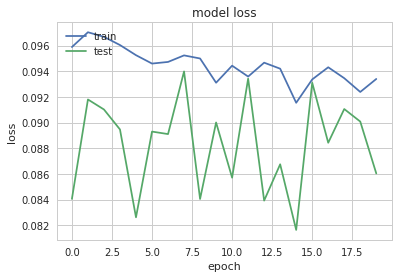

In [67]:

print(history_object2.history.keys())
plt.plot(history_object2.history['loss'])
plt.plot(history_object2.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [68]:
# go one level up to save final model
model_json = model.to_json()
with open("model_final.json", "w") as json_file:
    json_file.write(model_json)


model.save("model_final.h5")
print("Saved model to disk")

print(model.summary())


Saved model to disk
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding2d_1 (ZeroPadding2D)  (None, 162, 322, 3)   0           zeropadding2d_input_3[0][0]      
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 82, 322, 3)    0           zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
lambda_2 (Lambda)                (None, 64, 64, 3)     0           cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 32, 32, 24)    1824        lambda_2[0][0]                   
_______________________________________________________________________

### With above approach car is able to complete Track 1 but it was not able to perform well in Track 2 . During data collection we have not collected data from Track2.

<video controls src="IMG.mp4" />

#  Results:-
    please check final model file- Nvidias-check-24-0.0843.hdf5
    video file-> IMG.mp4
    youtube video link -> https://www.youtube.com/watch?v=x_zMxxjopok&feature=youtu.be